# Funciones de conexion con CHEMBL


Escribo una funcion para poder extraer datos de chembl-mysql directo desde python

In [11]:
import pandas as pd
import numpy as np

def mysql_pull(ip:str,ssh_usr:str,mysql_usr:str,ssh_pswd:str,mysql_pswd:str,db,query,mysql_ip:str='127.0.0.1',mysql_port:int = 3306):
    from sshtunnel import SSHTunnelForwarder
    from sqlalchemy import create_engine

    server = SSHTunnelForwarder(
        (ip, 22),
        ssh_username=ssh_usr,
        ssh_password=ssh_pswd,
        remote_bind_address=(mysql_ip, mysql_port)
        )

    server.start()
    local_port = str(server.local_bind_port)
    engine = create_engine('mysql+pymysql://{}:{}@{}:{}/{}'.format(mysql_usr, mysql_pswd, mysql_ip, local_port, db))

    dataDF = pd.read_sql(query, con=engine)

    server.stop()
    return dataDF

# Funciones de limpieza y parseo

En funcion de los criterios de la publicacion y propios de los datos, defino una funcion que hace toda la limpieza, El proceso esta está mucho más detallado en data_procesing.ipynb

In [12]:
def deepscreen_cleaning(df_raw):
    df = df_raw.copy()

    col_names = {
    'compund_chembl_id':'comp_id',
    'target_chemb_id':'target',
    'standard_relation':'relation',
    'standard_units':'units',
    'standard_type':'type',
    'potential_duplicate':'potential_duplicates',
    'target_sequence':'sequence'
    }

    df = df.rename(columns=col_names)

    print(f'Entries previous null biactivity deletion {len(df.index)}')
    df = df[~df.bioactivity.isnull()]
    print(f'Entries after null biactivity deletion {len(df.index)}')

    print(f'Entries previous bioactivity unification {len(df.index)}')
    df = df.groupby(['target','comp_id','relation','type','smiles','sequence','molregno','units'],as_index=False)['bioactivity'].median()
    print(f'Entries after bioactivity unification {len(df.index)}')

    print(f'Entries previous bioactivity binarization {len(df.index)}')
    def step_func_bioactivity(x):
        if x <= 10000: 
            return 1 
        elif x >= 20000:
            return 0
        else:
            return 'mal'
    df['binary_bioactivity'] = df['bioactivity'].apply(step_func_bioactivity)
    df = df[~(df.binary_bioactivity == 'mal')]
    print(f'Entries after bioactivity binarization {len(df.index)}')

    print(f'Entries previous assay type conflict cleaning {len(df.index)}')
    # Se conserva solo los que tengan una bioactividad binaria igual para todos los ensayos
    df = df.groupby(['comp_id','target','relation'],as_index=False).filter(lambda g: (g['binary_bioactivity'].nunique() == 1))
    # Se descartan los duplicados y se conserva aleatoriamente el primer resultado
    df = df.drop_duplicates(subset=['comp_id','target','relation'],keep='first')
    print(f'Entries after assay type conflict cleaning {len(df.index)}')

    print(f'Entries previous relation type conflict cleaning {len(df.index)}')
    df = df.drop_duplicates(subset=['comp_id','target'],keep=False)
    print(f'Entries after relation type conflict cleaning {len(df.index)}')

    print(f'Entries previous minimum 100 assays threshold filter {len(df.index)}')
    gb_target_23 = df.groupby('target')
    cuantos_ensayos = gb_target_23['comp_id'].count()
    mas_100_ensayos = cuantos_ensayos[cuantos_ensayos>100].index
    df = df[df.target.isin(mas_100_ensayos)]
    print(f'Entries previous minimum 100 assays threshold filter {len(df.index)}')

    return df

In [13]:
def pivot_to_trypanosomatcs_deepscreen(df):
    df_pivot = df.copy()
    df_pivot = df_pivot[['target','comp_id','binary_bioactivity','smiles']].pivot(index='comp_id',columns='target',values='binary_bioactivity')
    df_pivot = df_pivot.reset_index()
    df_pivot = pd.merge(df_pivot,df[['comp_id','smiles']],how='left',on='comp_id')
    df_pivot = df_pivot.drop_duplicates()
    return df_pivot

# Funciones de extraccion de datos de autores

In [14]:
import sqlalchemy as sa

def author_json_extract(json_path:str,target_id:str,ssh_pass:str,mysql_pass:str,db:str):
    df = pd.read_json(json_path, orient='index')
    df = df.transpose()
    df = pd.concat([df.training,df.test,df.validation])
    df = df.dropna()
    df = pd.DataFrame(df.to_list())
    df = df.rename(columns={0:'comp_id',1:target_id})
    comp_id_tuple = tuple(df.comp_id.to_list())
    df_smiles = get_smiles_chembl(comp_id_tuple, ssh_pass=ssh_pass,mysql_pass=mysql_pass,db=db)
    df = pd.merge(df,df_smiles,how='left',left_on='comp_id',right_on='comp_id')
    return df

def get_smiles_chembl(comp_id_tuple:tuple, ssh_pass:str, mysql_pass:str, db:str = 'chembl_31'):
    '''given a tuple with comp_id it returns a pandas dataframe with all the compounds chembl id and its canonical smiles'''
    query_smiles = f'''
SELECT md.chembl_id, cmpstc.canonical_smiles
FROM compound_structures AS cmpstc 
JOIN molecule_dictionary AS md ON md.molregno = cmpstc.molregno
WHERE md.chembl_id IN {tuple(comp_id_tuple)}'''
    df_smiles = mysql_pull('rho','sjinich','sjinich',ssh_pass,mysql_pass,db=db,query=query_smiles)
    df_smiles = df_smiles.rename(columns={'chembl_id':'comp_id','canonical_smiles':'smiles'})
    return df_smiles

# Obtencion de datos crudos de chembl
Defino el query que se usa para extraer la informacion de chembl

In [15]:
query = '''
SELECT act.molregno, 
    md.chembl_id AS comp_id,
    trgd.chembl_id AS target,
    act.standard_relation AS relation,
    act.standard_value AS bioactivity,
    act.standard_units AS units,
    act.standard_type AS type,
    act.potential_duplicate,
    act.pchembl_value,
    ass.assay_organism,
    cmpstc.canonical_smiles AS smiles,
    cs.sequence AS sequence
FROM activities AS act
JOIN assays AS ass ON act.assay_id = ass.assay_id
JOIN target_dictionary AS trgd ON ass.tid = trgd.tid
JOIN compound_structures AS cmpstc ON act.molregno = cmpstc.molregno
JOIN molecule_dictionary AS md ON act.molregno = md.molregno
JOIN target_components AS tc ON ass.tid = tc.tid
JOIN component_sequences AS cs ON tc.component_id = cs.component_id
WHERE trgd.target_type = 'SINGLE PROTEIN'
AND ass.assay_type IN ('B','F')
AND act.standard_type IN ('IC50','EC50','AC50','Ki','Kd','Potency')
;
'''

In [16]:
from getpass import getpass

pass_mysql = getpass('mysql pass:')
pass_ssh = getpass('ssh pass:')
df_chembl_23_filter_raw = mysql_pull('rho','sjinich','sjinich',pass_ssh,pass_mysql,'chembl_23',query)
df_chembl_23_filter_raw

OperationalError: (pymysql.err.OperationalError) (1045, "Access denied for user 'sjinich'@'localhost' (using password: NO)")
(Background on this error at: http://sqlalche.me/e/14/e3q8)

In [ ]:
df_chembl_23_filter_raw.to_pickle('df_chembl_23.pickle')

In [ ]:

pass_mysql = getpass('mysql pass:')
pass_ssh = getpass('ssh pass:')
df_chembl_31_filter_raw = mysql_pull('rho','sjinich','sjinich',pass_ssh,pass_mysql,'chembl_31',query)
df_chembl_31_filter_raw

In [ ]:
df_chembl_31_filter_raw.to_pickle('df_chembl_31.pickle')

In [ ]:
authors_zip_file = '/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_autores/target_training_datasets.zip'

import zipfile
from io import BytesIO
from os import path

import getpass
pass_ssh = getpass.getpass('ssh pass:')
pass_mysql = getpass.getpass('mysql_pass:')

folder = '/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_autores/'

with zipfile.ZipFile(authors_zip_file,mode='r') as archive:
    files = archive.namelist()
    del files[0]
    for file in files:
        comp_id = file[:file.find('.zip')]
        filedata = BytesIO(archive.read(file))
        with zipfile.ZipFile(filedata) as archive_in:
            filedata_json = BytesIO(archive_in.read(path.join(comp_id,'train_val_test_dict.json')))
            df = author_json_extract(filedata_json,comp_id,pass_ssh,pass_mysql,'chembl_23')
            df.to_pickle(path.join(folder,comp_id+'.pickle'))
            

In [ ]:
df_test = pd.read_pickle('/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_autores/CHEMBL1075104.pickle')

In [ ]:
df_test[df_test.comp_id == 'CHEMBL88962']['smiles'].values

# Comparaciones de datasets general

In [ ]:
import pandas as pd

In [ ]:
df_chembl_23_filter = pd.read_pickle('/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_training/df_chembl_23_filter.pkl')

In [ ]:
df_chembl_23_filter

,target,comp_id,relation,type,smiles,sequence,molregno,units,bioactivity,binary_bioactivity
314,CHEMBL1075051,CHEMBL1089229,=,IC50,O=C(Nc1ccc2N=C(SC\C=C\c3ccccc3)N(Cc4ccccc4)C(=...,MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFQYFQRMTTVSSVEG...,623289,nM,900.00,1
315,CHEMBL1075051,CHEMBL1089230,=,IC50,CSC1=Nc2ccc(NCC=C)cc2C(=O)N1Cc3ccccc3,MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFQYFQRMTTVSSVEG...,623290,nM,600.00,1
316,CHEMBL1075051,CHEMBL1090563,=,IC50,CSC1=Nc2ccc(cc2C(=O)N1Cc3ccccc3)N(C\C=C\c4cccc...,MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFQYFQRMTTVSSVEG...,623337,nM,600.00,1
317,CHEMBL1075051,CHEMBL1090572,=,IC50,Cc1ccc2N=C(S)N(Cc3ccccc3)C(=O)c2c1,MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFQYFQRMTTVSSVEG...,623827,nM,30000.00,0
318,CHEMBL1075051,CHEMBL1090602,=,IC50,CSC1=Nc2ccc(C)cc2C(=O)N1Cc3ccccc3,MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFQYFQRMTTVSSVEG...,623829,nM,20000.00,0
...,...,...,...,...,...,...,...,...,...,...
845337,CHEMBL6184,CHEMBL715,=,Ki,CN1CCN(CC1)C2=Nc3ccccc3Nc4sc(C)cc24,MLLARMKPQVQPELGGADQLPEQPLRPCKTADLLVVKERNGVQCLL...,34197,nM,2000.00,1
845338,CHEMBL6184,CHEMBL716,=,Ki,OCCOCCN1CCN(CC1)C2=Nc3ccccc3Sc4ccccc24,MLLARMKPQVQPELGGADQLPEQPLRPCKTADLLVVKERNGVQCLL...,34234,nM,680.00,1
845339,CHEMBL6184,CHEMBL72,=,Ki,CNCCCN1c2ccccc2CCc3ccccc13,MLLARMKPQVQPELGGADQLPEQPLRPCKTADLLVVKERNGVQCLL...,6243,nM,0.78,1
845340,CHEMBL6184,CHEMBL85,=,Ki,CC1=C(CCN2CCC(CC2)c3noc4cc(F)ccc34)C(=O)N5CCCC...,MLLARMKPQVQPELGGADQLPEQPLRPCKTADLLVVKERNGVQCLL...,7714,nM,28000.00,0


In [ ]:
len(df_chembl_23_filter.target.unique()) # deberia dar 704 ;(

763

sacando los targets con menos de 100 ensayos veo que me faltan casi 100000 ensayos

In [ ]:
import os
targets_autores_archivos = os.listdir('/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_autores')

In [ ]:
targets_autores = [i[:i.find('.pickle')] for i in targets_autores_archivos]

In [ ]:
len(df_chembl_23_filter.target.unique())

763

Veo cuantos targets me sobran en mi dataset, comparado con los 704 de los autores

In [ ]:
len(df_chembl_23_filter[~df_chembl_23_filter.target.isin(targets_autores)].target.unique())

164

Okay, hay solo 164 extras, lo que me dice que tengo 600 targets bien, o sea que me comí 104 targets nada mas. Lo que me faltan son los ensayos.

El tema es que yo ya vi que en algunos casos me sobran ensayos a rolete.

Voy a tratar de ver cuales tienen de más y cuales de menos

In [1]:
def balance_compuestos(df):
    df_chembl_23_filter = df.copy()

    import os
    targets_autores_archivos = os.listdir('/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_autores')
    targets_autores = [i[:i.find('.pickle')] for i in targets_autores_archivos]
    
    balance_compuestos_positivos = pd.Series(dtype='int64')
    targets_ausentes = []

    for target in targets_autores:
        
        df_target = df_chembl_23_filter[df_chembl_23_filter.target == target]
        
        if len(df_target.index) > 1:
            mio_pos = df_target['comp_id'].unique()
            ensayos_mio = len(mio_pos)
        else:
            targets_ausentes.append(target)
            print(f'{target} ausente')
            continue
        
        try:
            df_autores = pd.read_pickle(f'/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_autores/{target}.pickle')
            autores_pos = df_autores[df_autores[target] == 1]
            ensayos_autores = len(autores_pos.index)
            blance = ensayos_mio - ensayos_autores
            balance_compuestos_positivos[target]=blance
            print(f'{target} balance hecho')
        except:
            print(f'Unable to open {target}.pickle')
            continue
    
    return balance_compuestos_positivos, targets_ausentes

In [ ]:
balance_compuestos_positivos = balance_compuestos_positivos.sort_values(key=lambda x:abs(x),ascending=False)

Que onda, estos compuestos estan en mi df mas crudo?

In [20]:
import pandas as pd
dtypes = {
    'molregno':'int64',
    'comp_id':'object',
    'tid':'int64',
    'target':'object',
    'relation':'object',
    'bioactivity':'float64',
    'units':'object',
    'type':'object',
    'potential_duplicates':'int64',
    'pchem_values':'object',
    'organism':'object',
    'assay_type':'object',
    'smiles':'object',
    'ichi':'object',
    'sequence':'object'
}

df_raw = pd.read_csv('/home/sebastian-wsl/data_chembl32_10_04_23.csv',sep='\t',names=list(dtypes),na_values=['\\N','NA'],index_col=False)
df_raw

,molregno,comp_id,tid,target,relation,bioactivity,units,type,potential_duplicates,pchem_values,organism,assay_type,smiles,ichi,sequence
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,808225.0,CHEMBL1384341,11758.0,CHEMBL1784,NaN,28183.8000,nM,Potency,0.0,NaN,Homo sapiens,F,COc1ccc2c(c1)c(CC(=O)NCc1cc([N+](=O)[O-])ccc1O...,TWKARRBOKOIBHF-UHFFFAOYSA-N,MAGAPGPLRLALLLLGMVGRAGPRPQGATVSLWETVQKWREYRRQC...
2,768422.0,CHEMBL1344538,11758.0,CHEMBL1784,NaN,8912.5000,nM,Potency,0.0,NaN,Homo sapiens,F,COc1cccc(-c2nnc3sc(-c4ccccn4)nn23)c1,FCOMZICKKZCWHE-UHFFFAOYSA-N,MAGAPGPLRLALLLLGMVGRAGPRPQGATVSLWETVQKWREYRRQC...
3,1084262.0,CHEMBL1703531,11758.0,CHEMBL1784,NaN,11220.2000,nM,Potency,0.0,NaN,Homo sapiens,F,C=C[C@@H]1c2cccc(C)c2N(S(=O)(=O)c2ccc(C)cc2)[C...,NRLZMQPJUWDZKN-IXCJQBJRSA-N,MAGAPGPLRLALLLLGMVGRAGPRPQGATVSLWETVQKWREYRRQC...
4,972497.0,CHEMBL1548613,11758.0,CHEMBL1784,NaN,11220.2000,nM,Potency,0.0,NaN,Homo sapiens,F,Nc1nn2cc(-c3ccc(Br)cc3)nc2c2ccccc12,ILCFXOKVYROPRQ-UHFFFAOYSA-N,MAGAPGPLRLALLLLGMVGRAGPRPQGATVSLWETVQKWREYRRQC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8570983,2352654.0,CHEMBL4445645,120599.0,CHEMBL5069380,=,1849.8000,NaN,Normalized abundances for DMSO,0.0,NaN,Homo sapiens,B,C[C@@H]1CN(c2ncc(Cl)c(Nc3ccc4c(c3)n(CCC(C)(C)O...,VFNPUAOAEFMXQI-GASCZTMLSA-N,MEAEETMECLQEFPEHHKMILDRLNEQREQDRFTDITLIVDGHHFK...
8570984,2352654.0,CHEMBL4445645,120599.0,CHEMBL5069380,=,1794.2000,NaN,Normalized abundances for compound,0.0,NaN,Homo sapiens,B,C[C@@H]1CN(c2ncc(Cl)c(Nc3ccc4c(c3)n(CCC(C)(C)O...,VFNPUAOAEFMXQI-GASCZTMLSA-N,MEAEETMECLQEFPEHHKMILDRLNEQREQDRFTDITLIVDGHHFK...
8570985,2352654.0,CHEMBL4445645,120599.0,CHEMBL5069380,=,-0.7124,NaN,LogFC,0.0,NaN,Homo sapiens,B,C[C@@H]1CN(c2ncc(Cl)c(Nc3ccc4c(c3)n(CCC(C)(C)O...,VFNPUAOAEFMXQI-GASCZTMLSA-N,MEAEETMECLQEFPEHHKMILDRLNEQREQDRFTDITLIVDGHHFK...
8570986,2352654.0,CHEMBL4445645,120599.0,CHEMBL5069380,=,34.9000,NaN,Normalized abundances for DMSO,0.0,NaN,Homo sapiens,B,C[C@@H]1CN(c2ncc(Cl)c(Nc3ccc4c(c3)n(CCC(C)(C)O...,VFNPUAOAEFMXQI-GASCZTMLSA-N,MEAEETMECLQEFPEHHKMILDRLNEQREQDRFTDITLIVDGHHFK...


2023-04-13 11:35:05,122| ERROR   | Socket exception: Connection reset by peer (104)


In [ ]:
def binary_biactivity(df):
    def step_func_bioactivity(row):
        relation = row['relation']
        bioactivity = row['bioactivity']

        if relation in ('=','<') and bioactivity <= 10000:
            return 1

        elif relation in ('=','>') and bioactivity >= 20000:
            return 0

        else:
            return 'mal'
    
    df['binary_bioactivity'] = df.apply(step_func_bioactivity,axis=1)
    df = df[df.binary_bioactivity != 'mal']
    return df

df_raw = binary_biactivity(df_raw)

In [ ]:
balance_pos, target_aus = balance_compuestos(df_raw)

CHEMBL1901 balance hecho
CHEMBL1293224 balance hecho
CHEMBL4111 balance hecho
CHEMBL2034 balance hecho
CHEMBL5414 balance hecho
CHEMBL4036 ausente
CHEMBL3242 balance hecho
CHEMBL4355 balance hecho
CHEMBL4234 balance hecho
CHEMBL4829 balance hecho
CHEMBL1836 balance hecho
CHEMBL5979 balance hecho
CHEMBL4427 balance hecho
CHEMBL3890 balance hecho
CHEMBL4306 balance hecho
CHEMBL5939 balance hecho
CHEMBL1859 balance hecho
CHEMBL3759 balance hecho
CHEMBL2730 balance hecho
CHEMBL2431 balance hecho
CHEMBL4005 balance hecho
CHEMBL3180 balance hecho
CHEMBL4441 balance hecho
CHEMBL1075228 balance hecho
CHEMBL2208 balance hecho
CHEMBL5471 balance hecho
CHEMBL3942 balance hecho
CHEMBL322 balance hecho
CHEMBL1792 balance hecho
CHEMBL2336 balance hecho
CHEMBL3663 balance hecho
CHEMBL267 balance hecho
CHEMBL3616 balance hecho
CHEMBL2035 balance hecho
CHEMBL2391 balance hecho
CHEMBL4481 balance hecho
CHEMBL2243 balance hecho
CHEMBL3286 balance hecho
CHEMBL248 balance hecho
CHEMBL3650 balance hecho
CHE

(-400.0, 10.0)

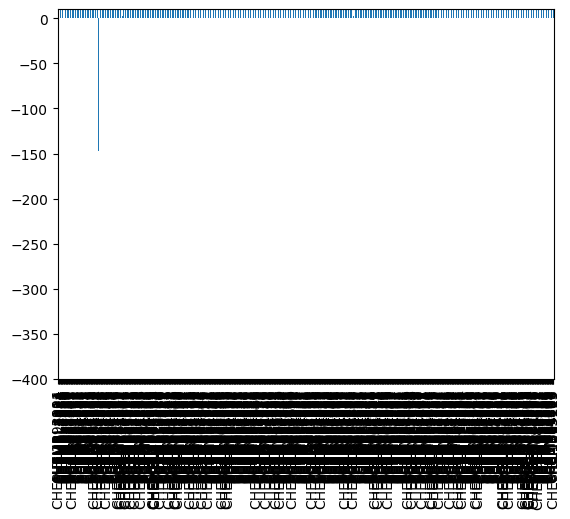

In [ ]:
plot = balance_pos.plot(kind='bar')

plot.set_ylim([-400,10])

In [10]:
target_aus_chembl32 = target_aus
balance_pos_chembl32 = balance_pos

In [ ]:
target_aus

['CHEMBL4036',
 'CHEMBL326',
 'train_val_test_dict.jso',
 'CHEMBL1904',
 'CHEMBL320',
 'CHEMBL308',
 'CHEMBL3385',
 'CHEMBL315',
 'CHEMBL311',
 'CHEMBL245',
 'CHEMBL5023',
 'CHEMBL4040',
 'target_training_datasets.zi',
 'CHEMBL276',
 'CHEMBL330',
 'CHEMBL331',
 'CHEMBL1781',
 'CHEMBL309',
 'CHEMBL301',
 'CHEMBL319']

In [ ]:
len(balance_pos[balance_pos < 0])

56

In [ ]:
df_raw_chembl32 = df_raw

In [ ]:
df_raw_chembl25 = pd.read_csv('/home/sebastian-wsl/data_chembl25_11_04_23.csv',sep='\t',names=list(dtypes),na_values=['\\N','NA'],index_col=False)
df_raw_chembl25

/home/sebastian-wsl/.conda/envs/deepscreen_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/sebastian-wsl/.conda/envs/deepscreen_env/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


,molregno,comp_id,tid,target,relation,bioactivity,units,type,potential_duplicates,pchem_values,organism,assay_type,smiles,sequence
0,1634114,CHEMBL3144823,104301,CHEMBL1907607,=,0.74,nM,IC50,0,9.13,Rattus norvegicus,B,Oc1cccc2ncc3C(=O)N(Nc3c12)c4ccccc4,KWWRQFCQHZCLNN-UHFFFAOYSA-N
1,942456,CHEMBL1518572,104301,CHEMBL1907607,=,1.00,nM,IC50,1,9.00,Rattus norvegicus,B,CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC,ALBKMJDFBZVHAK-UHFFFAOYSA-N
2,1633993,CHEMBL3144702,104301,CHEMBL1907607,>,1000000.00,nM,IC50,0,NaN,Rattus norvegicus,B,O=C1N(Nc2c1cnc3cccc(OCc4ccccc4)c23)c5ccccc5,RNYCHGPSWCHYCU-UHFFFAOYSA-N
3,1633991,CHEMBL3144700,104301,CHEMBL1907607,=,0.68,nM,IC50,0,9.17,Rattus norvegicus,B,COc1cccc2ncc3C(=O)N(Nc3c12)c4ccccc4,WAZYXENLQUTZEE-UHFFFAOYSA-N
4,1634151,CHEMBL3144860,104301,CHEMBL1907607,=,3.70,nM,IC50,0,8.43,Rattus norvegicus,B,O=C1N(Nc2c1cnc3ccc(OCc4ccccc4)cc23)c5ccccc5,PBEGQHTWHYWCLN-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7343140,2239729,CHEMBL4099818,117751,CHEMBL4106181,=,60.00,%,Activity,0,NaN,Mus musculus,B,CC(=O)N[C@@H]1[C@@H](NC(=N)N)C=C(O[C@H]1[C@H](...,GGROOSBUFJNXJU-LBQOOEJDSA-N
7343141,1941552,CHEMBL3559801,117748,CHEMBL4106178,NaN,NaN,NaN,Activity,0,NaN,Mus musculus,B,CC(C)(C)c1ccc(OC2CCCCC2O)cc1,FTIXUILRMBSXNS-UHFFFAOYSA-N
7343142,1941552,CHEMBL3559801,117748,CHEMBL4106178,NaN,NaN,NaN,Activity,0,NaN,Mus musculus,B,CC(C)(C)c1ccc(OC2CCCCC2O)cc1,FTIXUILRMBSXNS-UHFFFAOYSA-N
7343143,1941552,CHEMBL3559801,117748,CHEMBL4106178,NaN,NaN,NaN,Activity,0,NaN,Mus musculus,B,CC(C)(C)c1ccc(OC2CCCCC2O)cc1,FTIXUILRMBSXNS-UHFFFAOYSA-N


In [17]:
balance_pos_chembl25, target_aus_chembl25 = balance_compuestos(df_raw_chembl25)

CHEMBL1901 balance hecho
CHEMBL1293224 balance hecho
CHEMBL4111 balance hecho
CHEMBL2034 balance hecho
CHEMBL5414 balance hecho
CHEMBL4036 balance hecho
CHEMBL3242 balance hecho
CHEMBL4355 balance hecho
CHEMBL4234 balance hecho
CHEMBL4829 balance hecho
CHEMBL1836 balance hecho
CHEMBL5979 balance hecho
CHEMBL4427 balance hecho
CHEMBL3890 balance hecho
CHEMBL4306 balance hecho
CHEMBL5939 balance hecho
CHEMBL1859 balance hecho
CHEMBL3759 balance hecho
CHEMBL2730 balance hecho
CHEMBL2431 balance hecho
CHEMBL4005 balance hecho
CHEMBL3180 balance hecho
CHEMBL4441 balance hecho
CHEMBL1075228 balance hecho
CHEMBL2208 balance hecho
CHEMBL5471 balance hecho
CHEMBL3942 balance hecho
CHEMBL322 balance hecho
CHEMBL1792 balance hecho
CHEMBL2336 balance hecho
CHEMBL3663 balance hecho
CHEMBL267 balance hecho
CHEMBL3616 balance hecho
CHEMBL2035 balance hecho
CHEMBL2391 balance hecho
CHEMBL4481 balance hecho
CHEMBL2243 balance hecho
CHEMBL3286 balance hecho
CHEMBL248 balance hecho
CHEMBL3650 balance hec

(-400.0, 10.0)

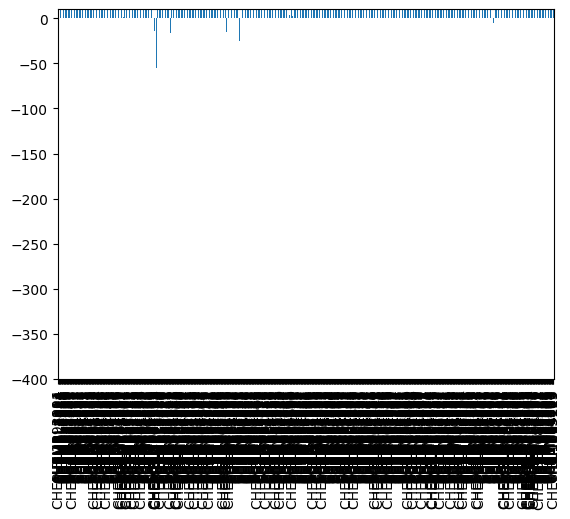

In [18]:
plot = balance_pos_chembl25.plot(kind='bar')

plot.set_ylim([-400,10])

In [19]:
target_aus_chembl25

['train_val_test_dict.jso', 'target_training_datasets.zi']

In [3]:
import pandas as pd
df_asinomas = pd.read_pickle('data_asi_nomas.pkl')

In [4]:
pos,aus = balance_compuestos(df_asinomas)

CHEMBL1901 balance hecho
CHEMBL1293224 balance hecho
CHEMBL4111 balance hecho
CHEMBL2034 balance hecho
CHEMBL5414 balance hecho
CHEMBL4036 balance hecho
CHEMBL3242 balance hecho
CHEMBL4355 balance hecho
CHEMBL4234 balance hecho
CHEMBL4829 balance hecho
CHEMBL1836 balance hecho
CHEMBL5979 balance hecho
CHEMBL4427 balance hecho
CHEMBL3890 balance hecho
CHEMBL4306 balance hecho
CHEMBL5939 balance hecho
CHEMBL1859 balance hecho
CHEMBL3759 balance hecho
CHEMBL2730 balance hecho
CHEMBL2431 balance hecho
CHEMBL4005 balance hecho
CHEMBL3180 balance hecho
CHEMBL4441 balance hecho
CHEMBL1075228 balance hecho
CHEMBL2208 balance hecho
CHEMBL5471 balance hecho
CHEMBL3942 balance hecho
CHEMBL322 balance hecho
CHEMBL1792 balance hecho
CHEMBL2336 balance hecho
CHEMBL3663 balance hecho
CHEMBL267 balance hecho
CHEMBL3616 balance hecho
CHEMBL2035 balance hecho
CHEMBL2391 balance hecho
CHEMBL4481 balance hecho
CHEMBL2243 balance hecho
CHEMBL3286 balance hecho
CHEMBL248 balance hecho
CHEMBL3650 balance hec

In [9]:
df_asinomas[df_asinomas.duplicated(subset=['comp_id','target'],keep=False)]

,molregno,comp_id,tid,target,relation,bioactivity,units,type,potential_duplicates,pchem_values,organism,target_type,assay_type,smiles,ichi_key,sequence,binary_bioactivity


(0.0, 3000.0)

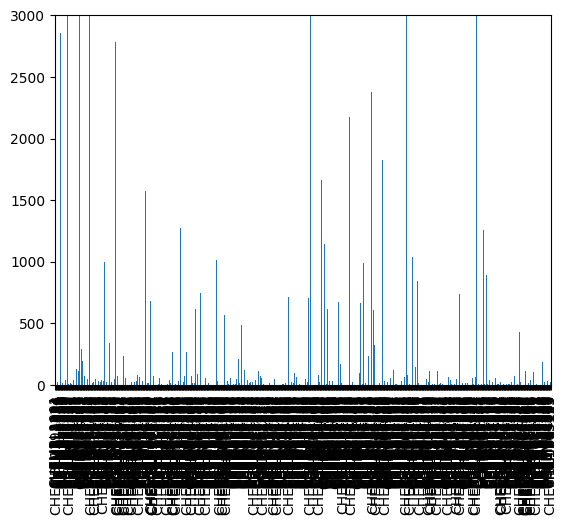

In [8]:
plot = pos.plot(kind='bar')


plot.set_ylim([0,3000])

# chembl2967


In [ ]:
authors_chembl2967 = pd.read_pickle('/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_autores/CHEMBL2967.pickle')
authors_chembl2967

In [ ]:
authors_chembl2967[authors_chembl2967.CHEMBL2967 == 1]

In [ ]:
mio_chembl2967 = pivot_to_trypanosomatcs_deepscreen(df_chembl_23_filter[df_chembl_23_filter.target == 'CHEMBL2967'])
mio_chembl2967

In [ ]:
mio_pos = mio_chembl2967[mio_chembl2967.CHEMBL2967 == 0].sort_values('comp_id')

In [ ]:
aut_pos = authors_chembl2967[authors_chembl2967.CHEMBL2967 == 0].sort_values('comp_id')

In [ ]:
mio_pos[~mio_pos.comp_id.isin(aut_pos.comp_id)]

In [ ]:
aut_pos[~aut_pos.comp_id.isin(mio_pos.comp_id)]

# Chembl286

In [ ]:
authors_chembl286 = pd.read_pickle('/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_autores/CHEMBL286.pickle')
authors_chembl286

In [ ]:
len(df_chembl_23_filter.comp_id.unique())

In [ ]:
chembl286 = df_chembl_23_filter[df_chembl_23_filter.target == 'CHEMBL286']
chembl286_pivot = pivot_to_trypanosomatcs_deepscreen(chembl286)
chembl286_pivot

In [ ]:
chembl286_pos_mio = chembl286_pivot[chembl286_pivot.CHEMBL286 == 1]

In [ ]:
chembl286_pos_auth = authors_chembl286[authors_chembl286.CHEMBL286==1]

In [ ]:
postive_comparison = pd.merge(chembl286_pos_auth,chembl286_pos_mio,how='outer', on='comp_id')

In [ ]:
postive_comparison[postive_comparison.comp_id == 'CHEMBL99989']

In [ ]:
chembl286_pos_auth.sort_values('comp_id').head(40)

In [ ]:
chembl286_pos_mio.sort_values('comp_id').head(40)

# dataset completo de autores

In [ ]:
import pandas as pd

In [ ]:
import os
path = '/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_autores'
targets_autores = os.listdir(path)

In [ ]:
base = pd.read_pickle('/home/sebastian-wsl/DEEPScreen/data_procesing_filter/data_autores/CHEMBL286.pickle')

In [ ]:
for target in targets_autores:
    try:
        base = pd.merge(base,pd.read_pickle(os.path.join(path,target)),on=['comp_id','smiles'],how='outer')
    except:
        pass

In [ ]:
base.to_pickle('./autores_dataset.pkl')

In [ ]:
base = base.drop('CHEMBL286_y',axis=1)


In [ ]:
base = base.rename(columns={'CHEMBL286_x' : 'CHEMBL286'})


In [ ]:
base.to_pickle('./autores_dataset.pkl')

In [ ]:
CHEMBL1901 = base[['comp_id','CHEMBL1901','smiles']]

In [ ]:
CHEMBL1901[~CHEMBL1901.CHEMBL1901.isna()]

In [ ]:
len(CHEMBL1901[(~CHEMBL1901.CHEMBL1901.isna()) & CHEMBL1901.smiles.isna()].index)

In [ ]:
from ..bin.deepscreen_trypanosomatics import trainer